In [3]:
import pylab
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib import gridspec
from ipywidgets import interact, interactive, fixed
from sklearn.pipeline import Pipeline
import ipywidgets as widgets
import pickle
import itertools
import os
import copy

import sklearn as skl
from sklearn import datasets
import torch
from nerus import load_nerus

np.random.seed(1)
import random

In [4]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

Вы собрали данные и их проанализировали, визуализировали и представили отчет своим партнерам и спонсорам. Они согласились, что ваша задача имеет перспективу и продемонстрировали заинтересованность в вашем проекте. Самое время реализовать прототип! Вы считаете, что нейронные сети переоценены (просто боитесь признаться, что у вас не хватает ресурсов и данных), и считаете что за машинным обучением классическим будущее и потому собираетесь использовать классические модели. Вашим первым предположением является предположение, что данные и все в этом мире имеет линейную зависимость, ведь не зря же в конце каждой нейронной сети есть линейный слой классификации. В качестве первых моделей вы выбрали, линейную / логистическую регрессию и SVM. Так как вы очень осторожны и боитесь ошибиться, вы хотите реализовать случай, когда все таки мы не делаем никаких предположений о данных, и взяли за основу идею "близкие объекты дают близкий ответ"  и идею, что теорема Байеса имеет ранг королевской теоремы. Так как вы не доверяете другим людям, вы хотите реализовать алгоритмы сами с нуля без использования scikit-learn (почти).  Вы хотите узнать насколько хорошо ваши модели работают на выбранных вам данных и хотите замерить метрики качества. Ведь вам нужно еще отчитаться спонсорам!

Формально говоря вам предстоит сделать следующее:
1) реализовать следующие алгоритмы машинного обучения: Linear/ Logistic Regression, SVM, KNN, Naive Bayes в отдельных классах    
2)  Данные классы должны наследоваться от BaseEstimator и  ClassifierMixin, иметь методы fit и predict (подробнее: https://scikit-learn.org/stable/developers/develop.html )  
3) Вы должны организовать весь процесс предобработки, обучения и тестирования с помощью Pipeline (подробнее: https://scikit-learn.org/stable/modules/compose.html)    

4) Вы должны настроить гиперпараметры моделей с помощью кросс валидации (GridSearchCV,RandomSearchCV, подробнее здесь:   https://scikit-learn.org/stable/modules/grid_search.html), вывести и сохранить эти гиперпараметры в файл, вместе с обученными моделями   
5) Проделать аналогично с коробочными решениями  
6) Для каждой модели получить оценки метрик:Confusion Matrix,  Accuracy, Recall, Precision, ROC_AUC curve (подробнее: Hands on machine learning with python and scikit learn chapter 3, mlcourse.ai, https://ml-handbook.ru/chapters/model_evaluation/intro)

7) Проанализировать полученные результаты и сделать выводы о применимости моделей  
8) Загрузить полученные гиперпараметры модели и обученные модели в формате pickle  на гит вместе с jupyter notebook ваших экспериментов  

### Алгоритмы. Реализация и тестирование

#### Искуственный датасет для классификации:

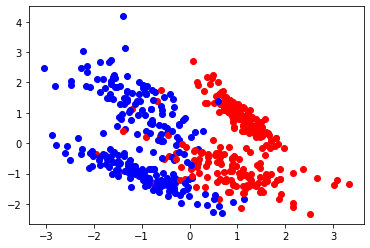

In [5]:
clm = datasets.make_classification(n_samples = 500,n_features = 2,n_informative = 2,n_redundant = 0,class_sep = 1,flip_y=0.05)

#генерация выборок
trainXX,valXX = (np.split(clm[0],[int(8*len(clm[0])/10)]))
trainLB,valLB = (np.split(clm[1],[int(8*len(clm[1])/10)]))

train_X = np.array([[t[0],t[1],1] for i,t in enumerate(trainXX)])

pos_examples = np.array([ [t[0],t[1],1] for i,t in enumerate(trainXX) 
                          if trainLB[i]>0])
neg_examples = np.array([ [t[0],t[1],1] for i,t in enumerate(trainXX) 
                          if trainLB[i]<1])
#визуализация
for i in range(len(clm[1])):
    if(clm[1][i] > 0):
        plt.plot(clm[0][i][0],clm[0][i][1],'ro')
    if(clm[1][i] < 1):
        plt.plot(clm[0][i][0],clm[0][i][1],'bo')

plt.show()

#### Метрики

In [6]:
#кривая порог - точность
#очень помогает определить оптимальный дискриминант

def DAC(model,data,labels,d_span = [0,1]):
    real_d = model.d
    
    line_x = []
    line_y = []
    
    for d in range(100*d_span[0],100*d_span[1]):
        di = d*0.01
        model.set_d(di)
        line_x.append(di)
        line_y.append(model.accuracy(data,labels))
    
    pylab.grid()
    pylab.xlim(d_span[0], d_span[1])
    pylab.ylim(0,1)   
    pylab.xlabel('d (порог)')
    pylab.ylabel('accuracy')
    pylab.plot(line_x,line_y)
    
    model.set_d(real_d)
    
#кривая порог - точность
#очень помогает определить оптимальный дискриминант

def DACforPipe(model,data,labels,d_span = [0,1]):
    real_d = model[1].d
    
    line_x = []
    line_y = []
    
    for d in range(100*d_span[0],100*d_span[1]):
        di = d*0.01
        model[1].set_d(di)
        line_x.append(di)
        line_y.append(model.score(data,labels))
    
    pylab.grid()
    pylab.xlim(d_span[0], d_span[1])
    pylab.ylim(0,1)   
    pylab.xlabel('d (порог)')
    pylab.ylabel('accuracy')
    pylab.plot(line_x,line_y)
    
    model[1].set_d(real_d)

In [7]:
def basic_metrics(model,data,labels,silent = True):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(labels)):
        res = model.predict([data[i]])
        if(res == labels[i] and res == 1):
            TP += 1
        if(res == labels[i] and res == 0):
            TN += 1
        if(res != labels[i] and res == 1):
            FP += 1
        if(res != labels[i] and res == 0):
            FN += 1
            
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    if(TP + FP == 0):
        precision = 0
    else:
        precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    specificity = TN/(TN + FP)
    sencitivity = TP/(TP + FN)
    
    if(not silent):
        print("accuracy: {} (чем больше ложных, тем меньше)".format(accuracy))
        print(
            "precision: {} (чем больше ложнопозитивных, тем меньше)".format(precision))
        print("recall: {} (чем больше ложнонегативных, тем меньше)".format(recall))
        print("specificity: {} (чем больше негативных классифицировано неверно, тем меньше)".format(specificity))
        print("sencitivity: {} (чем больше позитивных классифицировано неверно, тем меньше)".format(sencitivity))
    
    return (accuracy,precision,recall,specificity,sencitivity)

In [8]:
def roc(model,data,labels,d_span = [0,1],unlock_borders = False):
    real_d = model.d
    
    line_x = []
    line_y = []
    
    for d in range(100*d_span[0],100*d_span[1]):
        di = d*0.01
        model.set_d(di)
        line_x.append(1 - basic_metrics(model,data,labels)[3])
        line_y.append(basic_metrics(model,data,labels)[4])
    
    pylab.grid()
    if not (unlock_borders):
        pylab.xlim(0, 1)
        pylab.ylim(0, 1)   
    pylab.xlabel('1 - specificity')
    pylab.ylabel('sencitivity')
    pylab.plot(line_x,line_y)
    pylab.plot([0,1],[0,1], 'g-')
    
    model.set_d(real_d)
    
def rocForPipe(model,data,labels,d_span = [0,1],unlock_borders = False):
    real_d = model[1].d
    
    line_x = []
    line_y = []
    
    for d in range(100*d_span[0],100*d_span[1]):
        di = d*0.01
        model[1].set_d(di)
        line_x.append(1 - basic_metrics(model,data,labels)[3])
        line_y.append(basic_metrics(model,data,labels)[4])
    
    pylab.grid()
    if not (unlock_borders):
        pylab.xlim(0, 1)
        pylab.ylim(0, 1)   
    pylab.xlabel('1 - specificity')
    pylab.ylabel('sencitivity')
    pylab.plot(line_x,line_y)
    pylab.plot([0,1],[0,1], 'g-')
    
    model[1].set_d(real_d)

In [9]:
def confusion_matrix(model, data, labels,
                     class_names,
                     normalize=False,
                     title='Confusion matrix',
                     do_print = True,
                     shrink = 1):
    #реультат классификации
    predicted_lb = []
    for a in data:
        predicted_lb.append(model.predict([a]))
    #построение матрицы
    n_cl = len(np.unique(labels))
    matr = np.zeros([n_cl,n_cl])
    for i in range (len(labels)):
        matr[labels[i],predicted_lb[i]] += 1
    #отображение матрицы    
    pylab.imshow(matr, interpolation='nearest', cmap=pylab.cm.Blues)
    pylab.title(title)
    pylab.colorbar()
    tick_marks = np.arange(len(class_names))
    pylab.xticks(tick_marks, class_names, rotation=45)
    pylab.yticks(tick_marks, class_names)

    matr = (matr.astype('float')/shrink).astype('int')
    
    if normalize:
        matr = matr.astype('float') / matr.sum(axis=1)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    
    thresh = matr.max() / 2.
    if(do_print):
        for i, j in itertools.product(range(matr.shape[0]), range(matr.shape[1])):
              pylab.text(j, i, np.round((matr[i, j]),2),
                    color="white" if matr[i, j] > thresh else "black")
                
    pylab.ylabel('True label')
    pylab.xlabel('Predicted label')
    pylab.show()

#### 1.1 Линейная регрессия

In [10]:
class linear_regression(skl.base.ClassifierMixin):
    
    def __init__(self,n_feat,lr = 0.05,d = 0):
        self.w = np.zeros(n_feat + 1)
        self.d = d
        self.lr = lr
        
    def wts(self):
        return self.w
    
    def set_d(self,new_d):
        self.d = new_d
        
    def predict(self,feats_): # кассификация (положительный/отрицательный результат в зависимости от того, 
                              # преодолевает ли предстказанное значение дискриминант)
        feats = feats_[0]
        
        score = np.sum((np.dot(feats,self.w[0:len(feats)])))
        
        return int(score > self.d)
    
    def linres(self,feats_): # предсказанное значение f(feats)
        feats = feats_[0]
        
        score = np.sum((np.dot(feats,self.w[0:len(feats)])))
        
        return score
            
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/total
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def fit(self,data,labels,rr = 50):
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(np.matrix(data)),
                                                    np.matrix(data))),
                              (np.transpose(np.matrix(data)))),
                        np.transpose(np.matrix(labels)))

Проверка на искуственном датасете

accuracy with train set: 0.925
accuracy with test set: 0.9


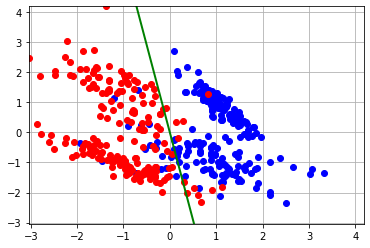

In [11]:
tst = linear_regression(2)

tst.fit(trainXX,trainLB)
print("accuracy with train set: {}".format(tst.accuracy(trainXX,trainLB)))
print("accuracy with test set: {}".format(tst.accuracy(valXX,valLB)))

plot_boundary_L(pos_examples,neg_examples,np.array(tst.wts()))

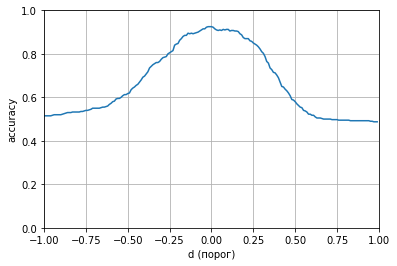

In [12]:
DAC(tst,trainXX,trainLB,d_span = [-1,1])

In [13]:
metr = basic_metrics(tst,trainXX,trainLB,silent = False)

accuracy: 0.925 (чем больше ложных, тем меньше)
precision: 0.94 (чем больше ложнопозитивных, тем меньше)
recall: 0.912621359223301 (чем больше ложнонегативных, тем меньше)
specificity: 0.9381443298969072 (чем больше негативных классифицировано неверно, тем меньше)
sencitivity: 0.912621359223301 (чем больше позитивных классифицировано неверно, тем меньше)


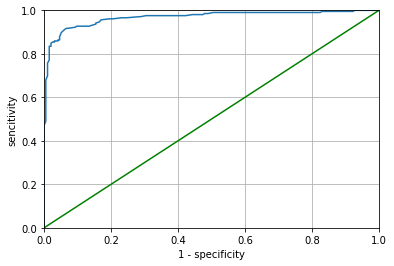

In [14]:
roc(tst,trainXX,trainLB,d_span = [-1,1])

Normalized confusion matrix


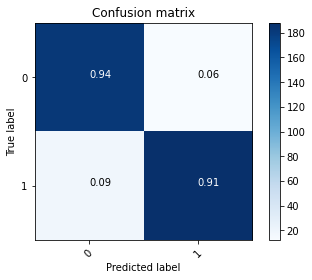

In [15]:
confusion_matrix(tst,trainXX,trainLB,["0","1"],normalize = True)

#### 1.2 Логистическая регрессия

In [16]:
class logistic_regression(skl.base.ClassifierMixin):
    
    def __init__(self,n_feat,lr = 0.1,d = 0.5):
        self.w = np.zeros(n_feat + 1)
        self.d = d
        self.lr = lr
        
    def wts(self):
        return self.w
        
    def predict(self,feats_,d = -1):
        feats = feats_[0]
        
        score = np.sum(np.dot(self.w[0:len(feats)],feats))
        
        if(d == -1 or (d < 0) or (d > 1)):
            d = self.d
        prob = 1/(1 + np.exp(-score))
        
        return int(prob > d)
    
    def logit(self,feats_):
        feats = feats_[0]
        
        score = np.sum(np.dot(self.w[0:len(feats)],feats))
        return 1/(1 + np.exp(-score))
    
    def set_d(self,new_d):
        self.d = new_d
     
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/total
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def fit(self,data,labels,rr = 50):
        
        if(rr == 0):
            rr = len(labels) + 1
        print("")
        
        for i in range(len(labels)):
            lr = self.lr
                        
            sc = self.logit([data[i]])
            self.w += (labels[i] - sc)*data[i]*lr


accuracy with train set: 0.9275
accuracy with test set: 0.9


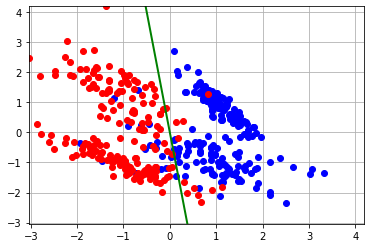

In [17]:
tst = logistic_regression(2)

tst.fit(train_X,trainLB)
print("accuracy with train set: {}".format(tst.accuracy(trainXX,trainLB)))
print("accuracy with test set: {}".format(tst.accuracy(valXX,valLB)))

plot_boundary_L(pos_examples,neg_examples,np.array(tst.wts()))

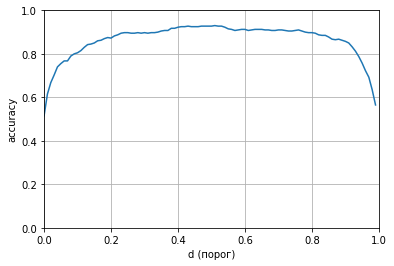

In [18]:
DAC(tst,trainXX,trainLB,d_span = [0,1])

In [19]:
metr = basic_metrics(tst,trainXX,trainLB,silent = False)

accuracy: 0.9275 (чем больше ложных, тем меньше)
precision: 0.9402985074626866 (чем больше ложнопозитивных, тем меньше)
recall: 0.9174757281553398 (чем больше ложнонегативных, тем меньше)
specificity: 0.9381443298969072 (чем больше негативных классифицировано неверно, тем меньше)
sencitivity: 0.9174757281553398 (чем больше позитивных классифицировано неверно, тем меньше)


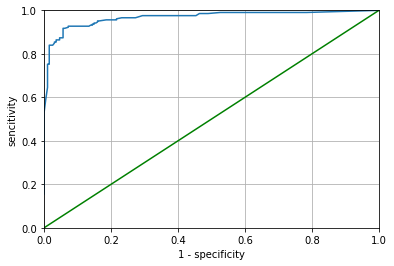

In [20]:
roc(tst,trainXX,trainLB,d_span = [0,1])

Normalized confusion matrix


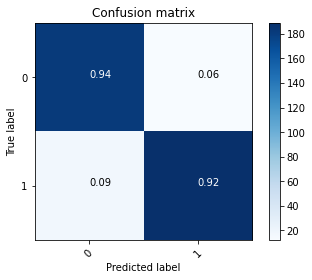

In [21]:
confusion_matrix(tst,trainXX,trainLB,["0","1"],normalize = True)

#### 2. SVM

In [22]:
class SVM(skl.base.ClassifierMixin):
    
    def __init__(self,n_feat,lr = 0.05,d = 0.9):
        self.w = np.zeros(n_feat + 1)
        self.d = d
        self.lr = lr
        
    def wts(self):
        return self.w
        
    def predict(self,feats_):
        feats = feats_[0]
        
        score = np.sum(np.dot(self.w[0:len(feats)],feats))
        
        prob = 1/(1 + np.exp(-score))
        
        return int(prob > self.d)
    
    def set_d(self,new_d):
        self.d = new_d
    
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/total
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
        
    def fit(self,data,labels, alpha = 0.1,silent = True):
                
        for i in range(len(labels)):
            lr = self.lr
            
            cl = self.predict([data[i]])
            
                   
            if(cl < self.d and labels[i] == 1):
                self.w += (data[i])*lr
            
            if(cl > self.d and labels[i] == 0):
                self.w -= (data[i])*lr 
                
            self.w += alpha * self.w * lr
    

accuracy with train set: 0.905
accuracy with test set: 0.9


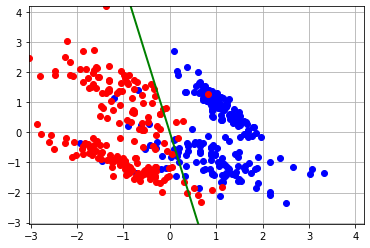

In [23]:
tst = SVM(2)
tst.fit(train_X,trainLB,silent = False)
print("accuracy with train set: {}".format(tst.accuracy(trainXX,trainLB)))
print("accuracy with test set: {}".format(tst.accuracy(valXX,valLB)))
plot_boundary_L(pos_examples,neg_examples,np.array(tst.wts()))

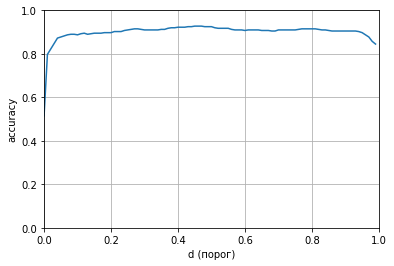

In [24]:
DAC(tst,trainXX,trainLB,d_span = [0,1])

In [25]:
metr = basic_metrics(tst,trainXX,trainLB,silent = False)

accuracy: 0.905 (чем больше ложных, тем меньше)
precision: 0.9827586206896551 (чем больше ложнопозитивных, тем меньше)
recall: 0.8300970873786407 (чем больше ложнонегативных, тем меньше)
specificity: 0.9845360824742269 (чем больше негативных классифицировано неверно, тем меньше)
sencitivity: 0.8300970873786407 (чем больше позитивных классифицировано неверно, тем меньше)


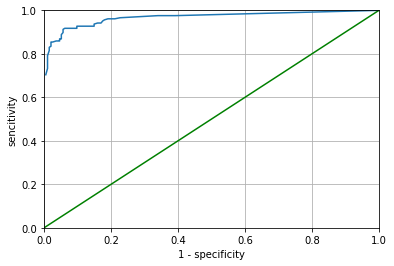

In [26]:
roc(tst,trainXX,trainLB,d_span = [0,1])

Confusion matrix, without normalization


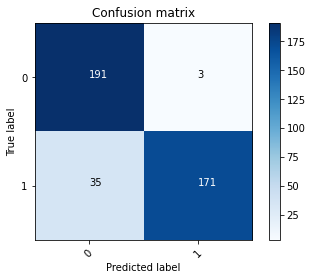

In [27]:
confusion_matrix(tst,trainXX,trainLB,["0","1"],normalize = False)

#### 3. KNN

In [144]:
class KNN(skl.base.ClassifierMixin): #svm (soft-margin)
    
    def __init__(self,k = 5):
        if(k % 2 == 0):
            k+=1
            
        if(k <= 0):
            return -1
            
        self.k = k
        
    def set_d(self,new_d):
        self.k = new_d
              
    def predict(self,feats_,silent = True):
        feats = feats_[0]
        
        mins = np.zeros([self.k,2]) - 1
        mqs = []
        
        j=0
        for cur in self.examples:
            j += 1
            dist = np.linalg.norm(feats - cur[0]) #расстояние между точками
            
            for i in range(len(mins)):
                if(dist < mins[i][0] or mins[i][0] < 0):
                    mins[i][0] = dist
                    mins[i][1] = cur[1]
                    mqs.append(cur[0])
                    break
                    
        
        score = np.zeros(len(self.classes))
        for a in mins:
            score[int(a[1])] += 1
                          
        if(not silent):
            print("---------")
            print("input feats: {}".format(feats))
            print("closest obj: {}".format(mqs[len(mqs) - self.k : len(mqs)]))
            
            return (np.argmax(score)),(mqs[len(mqs) - self.k : len(mqs)])
        return (np.argmax(score))
              
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/total    
    
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def fit(self,data,labels):          
        self.examples = []
        for i in range(len(data)):
            self.examples.append([data[i],labels[i]])
        self.examples = np.array(self.examples,dtype=object)
        self.classes = np.unique(labels)

In [29]:
tst = KNN(5)

tst.fit(trainXX,trainLB)
print("accuracy with train set: {}".format(tst.accuracy(trainXX,trainLB)))
print("accuracy with test set: {}".format(tst.accuracy(valXX,valLB)))

accuracy with train set: 0.9425
accuracy with test set: 0.93


In [30]:
metr = basic_metrics(tst,trainXX,trainLB,silent = False)

accuracy: 0.9425 (чем больше ложных, тем меньше)
precision: 0.9552238805970149 (чем больше ложнопозитивных, тем меньше)
recall: 0.9320388349514563 (чем больше ложнонегативных, тем меньше)
specificity: 0.9536082474226805 (чем больше негативных классифицировано неверно, тем меньше)
sencitivity: 0.9320388349514563 (чем больше позитивных классифицировано неверно, тем меньше)


Normalized confusion matrix


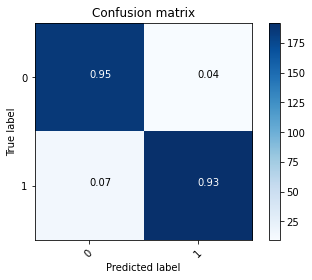

In [31]:
confusion_matrix(tst,trainXX,trainLB,["0","1"],normalize = True)

#### 4. Naive Bayes

In [32]:
class Naive_Bayes(skl.base.ClassifierMixin): 
    #базовый наивный байесовский алгоритм
    def __init__(self):
        0 == 0
                
    def predict(self,feats_,silent = True):
        feats = feats_[0]
        score = copy.deepcopy(self.cl_freq)
        
        for i in range(len(score)):
            for cur in feats:
                if(np.array(cur,dtype = np.intc).tolist() in self.uni.tolist()):
                    score[i] *= self.feat_freq[i][self.uni.tolist().index(np.array(cur,dtype = np.intc).tolist())]
        cl = np.argmax(score)
        
        return cl
        
    def _score(self,feats_):
        feats = feats_[0]
        score = copy.deepcopy(self.cl_freq)
        
        for i in range(len(score)):
            for cur in feats:
                if(np.array(cur,dtype = np.intc).tolist() in self.uni.tolist()):
                    score[i] *= self.feat_freq[i][self.uni.tolist().index(np.array(cur,dtype = np.intc).tolist())]
        return score
      
    def accuracy(self,data,labels):
        total = 0
        correct = 0
        for i in range(len(labels)):
            total += 1
            if(self.predict([data[i]]) == labels[i]):
                correct += 1
        return correct/total  
    
    def score(self,data,labels):
        return self.accuracy(data,labels)
    
    def status(self):
        print("classes | freq:")
        print(self.cl_freq)
        print("features | freq: ")
        print(self.feat_freq)
        
    def fit(self,data,labels):
                               #должны учитываться только признаки, которые есть во всех классах
                
        #data представляет из себя массив массивов возмможно переменной длины,
        #в каждом из которых находятся теги, принадл. данному эементу
        
        self.cl_freq = np.zeros(np.max(labels) + 1)
        for i in labels:
            self.cl_freq[i] += 1
            
        #список уникальных признаков
        #признаками считаются элементы массива признаков целиком 
        #([[1,2],[3,4]) - признак №1 = [1,2], признак №2 = [3,4]
        
        self.uni = []
        for cur in data:
            for a in cur:
                b = np.array(a,dtype = np.intc).tolist()
                if not b in self.uni:
                    self.uni.append(b)
        self.uni = np.array(self.uni)
            
        #частоты признаков в классах
        self.feat_freq = np.zeros([len(self.cl_freq),len(self.uni)])
        
        for i in range(len(labels)):
            for j in range(len(data[i])):
                #в списке уникальных признаков находим текущий признак, и по его индексу инкриментируем элемент в списке частотности признаков в классах
                self.feat_freq[int(labels[i])][self.uni.tolist().index(np.array(data[i][j],dtype = np.intc).tolist())] += 1
                

In [33]:
#для работы с алгоритмом байеса нужно модифицировать массивы с данными
#признаками считаются элементы массивов первого порядка
#нам надо использовать в качестве признаков координатные пары (округленные до целых)
#округление производится самим алгоритмом (может тоже надо вынести в предобработку)
train_O = np.reshape(trainXX,[len(trainXX),1,2])
val_O = np.reshape(valXX,[len(valXX),1,2])

tst = Naive_Bayes()

tst.fit(train_O,trainLB)
print("accuracy with train set: {}".format(tst.accuracy(train_O,trainLB)))
print("accuracy with test set: {}".format(tst.accuracy(val_O,valLB)))

accuracy with train set: 0.83
accuracy with test set: 0.77


In [34]:
metr = basic_metrics(tst,train_O,trainLB,silent = False)

accuracy: 0.83 (чем больше ложных, тем меньше)
precision: 0.7851239669421488 (чем больше ложнопозитивных, тем меньше)
recall: 0.9223300970873787 (чем больше ложнонегативных, тем меньше)
specificity: 0.7319587628865979 (чем больше негативных классифицировано неверно, тем меньше)
sencitivity: 0.9223300970873787 (чем больше позитивных классифицировано неверно, тем меньше)


Normalized confusion matrix


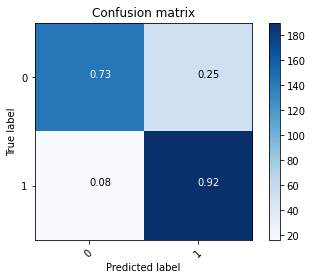

In [35]:
confusion_matrix(tst,train_O,trainLB,["0","1"],normalize = True)

### Подготовка данных

In [36]:
Classes = []
selLen = 1000

for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM" and 
               token.pos != "AUX" and token.pos != "NUM" and token.pos != "SCONJ"  and 
               token.pos != "PRON" and token.pos != "DET" and token.pos != "PROPN" and 
               token.pos != "INTJ"):
                
                 if(not token.pos in Classes): #на всякий случай
                        Classes.append(token.pos)

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

Classes

['NOUN', 'ADP', 'ADJ', 'VERB', 'ADV', 'CCONJ', 'PART']

In [37]:
ClassesRU = ["СУЩ","ПРЕД","ПРИЛ","ГЛАГ","НАР","СЧСОЮЗ","ПРИЧ"]

def ClassConvToRU(cl):
    for i in range(len(Classes)):
        if(cl == Classes[i]):
            return ClassesRU[i]
        
def ClassConvToEN(cl):
    for i in range(len(Classes)):
        if(cl == ClassesRU[i]):
            return Classes[i]
        
def classnum(cl): #перевод из имен классов в индексы
    for i in range(len(Classes)):
        if(cl == Classes[i]):
            return i
    return -1

In [38]:
alphabet = ['а', 'е', 'ё', 'и', 'о', 'у', 'ы', 'э', 'ю', 'я', 
            'б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ',
            'ь', 'ъ']

def LetterPos(l):
    try: 
        return alphabet.index(l)
    except(BaseException):
        return -1
    
def wordAsArray(word):
    res = []
    for cur in word:
        res.append(LetterPos(cur))
    return res

def boolArr(letter): #создать zeros-like по алфавиту с 1 в индексе данной буквы
    arr = []
    for a in alphabet:
        if(a == letter):
            arr.append(1)
        else:
            arr.append(0)
            
    return np.array(arr)

count of classes in dataset:


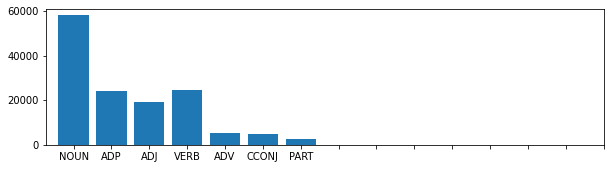

averege len:


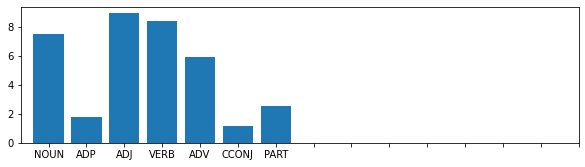

In [39]:
CllenAvg = [0 for i in range(len(Classes))] #среднее значение длины слова соответствующего класса
ClCnt = [0 for i in range(len(Classes))] #сколько слов каждого класса встретилось

for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                clN = classnum(token.pos)
                CllenAvg[clN] += len(token.text)
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    CllenAvg[i] /= ClCnt[i]

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

print("count of classes in dataset:")
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(2.5) 

ax.bar(Classes,ClCnt)
pylab.xticks(np.arange(15))
pylab.show()

print("averege len:")
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(2.5) 

ax.bar(Classes,CllenAvg)
pylab.xticks(np.arange(15))
pylab.show()

### Составление датасета

In [40]:
def create_dataset(selLen = 5000,ClLen = 500):
    #W равное число экземпляров каждого класса
    #по 5000

    ClCnt = [0 for i in range(len(Classes))]

    larrLB = []
    larrDC = [] #сами слова
    
    docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

    for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
        doc = next(docs)
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in Classes):
                        clN = classnum(token.pos)

                        if(ClCnt[clN] < ClLen):

                            ClCnt[clN] += 1

                            larrLB.append(classnum(token.pos)) #мб стоит преобразовать в численный тег))])
                            larrDC.append(token.text) #



    ClCnt = [0 for i in range(len(Classes))]

    tarrLB = []
    tarrDC = [] #сами слова

    for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
        doc = next(docs)
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in Classes):
                        clN = classnum(token.pos)

                        if(ClCnt[clN] < ClLen):

                            ClCnt[clN] += 1

                            tarrLB.append(classnum(token.pos)) #мб стоит преобразовать в численный тег))])
                            tarrDC.append(token.text) #

    docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

    return larrLB,larrDC,tarrLB,tarrDC

In [41]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset()

In [42]:
def CarArr(_word):
    word = copy.deepcopy(_word)
    
    if(len(word) < 3):
        res = np.array([len(word),
                        LetterPos(word[0]),
                        LetterPos(('a')),
                        LetterPos((word[len(word) - 2])),
                        LetterPos((word[len(word) - 1]))], dtype = object)
    else:
        res = np.array([len(word),
                        LetterPos(word[0]),
                        LetterPos((word[len(word) - 2])),
                        LetterPos((word[len(word) - 2])),
                        LetterPos((word[len(word) - 1]))], dtype = object)
    return res

## 1: признаки - буквы слова

трансформер для выделения признаков

In [56]:
class transform(skl.base.TransformerMixin):
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = wordAsArray(a[i])
            
        return res

In [57]:
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)

Pipeline(steps=[('transformer',
                 <__main__.transform object at 0x000001C07CC58E80>),
                ('classifier',
                 <__main__.Naive_Bayes object at 0x000001C07D61E6E0>)])

In [58]:
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

accuracy on train set:
0.39371428571428574
accuracy on test set:
0.3914285714285714


#### Числа на матрице спутывания меньше реального числа классифицированных объектов в 10 раз

Confusion matrix, without normalization


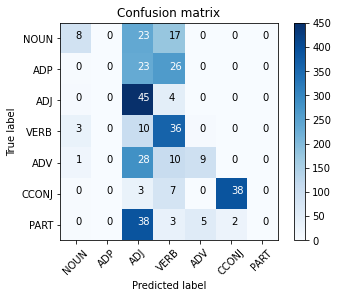

Confusion matrix, without normalization


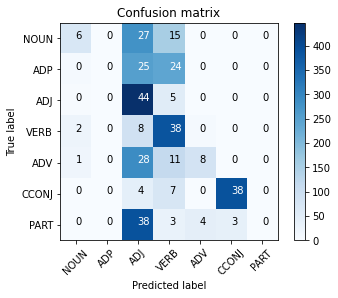

In [59]:
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 10)
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

## 2: Массив признаков

In [105]:
class transform(skl.base.TransformerMixin):
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = CarArr(a[i])
            
        return res

In [236]:
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)

Pipeline(steps=[('transformer',
                 <__main__.transform object at 0x000001736ACB3F40>),
                ('classifier',
                 <__main__.Naive_Bayes object at 0x00000173694F7A30>)])

accuracy on train set:
0.6931428571428572
accuracy on test set:
0.6711428571428572
Confusion matrix, without normalization


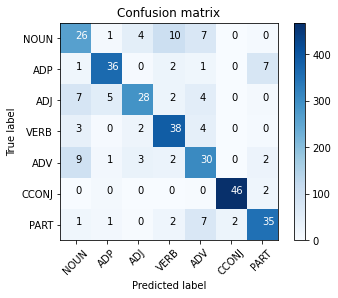

Confusion matrix, without normalization


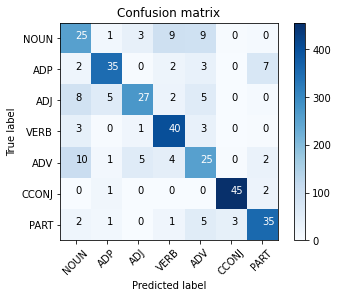

In [237]:
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 10)
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

По умолчанию в качестве признаков берется длина, первая буква и три последних. Чтобы оптимизировать модель, посмотрим, как исключение нескольких признаков влияет на точность классификации:

In [98]:
def CarArr(_word):
    word = copy.deepcopy(_word)
    
    if(len(word) < 3):
        res = np.array([
                        len(word),
                        LetterPos(word[0]),
                        LetterPos((word[len(word) - 1]))
                        ], dtype = object)
    else:
        res = np.array([
                        len(word),
                        LetterPos(word[0]),
                        LetterPos(word[len(word) - 1])
                        ], dtype = object)
    return res

In [99]:
class transform(skl.base.TransformerMixin):
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = CarArr(a[i])
            
        return res

## Только длина:

accuracy on train set:
0.48942857142857144
accuracy on test set:
0.4634285714285714
train set:
Confusion matrix, without normalization


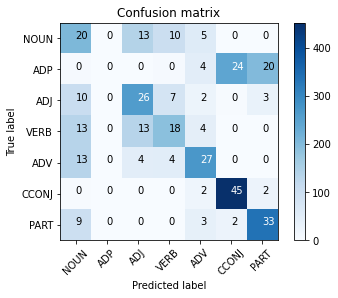

test set:
Confusion matrix, without normalization


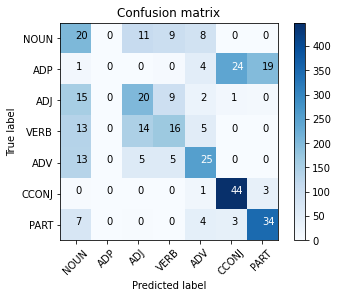

In [68]:
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 10)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

## Первая + последня буква:

accuracy on train set:
0.6202857142857143
accuracy on test set:
0.598
train set:
Confusion matrix, without normalization


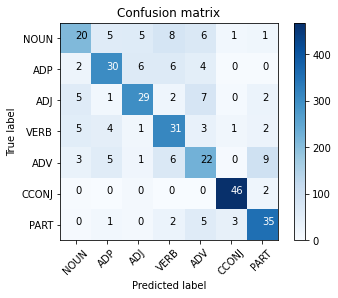

test set:
Confusion matrix, without normalization


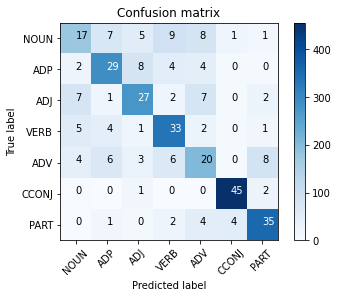

In [95]:
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 10)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

## Длина + первая буква

accuracy on train set:
0.604
accuracy on test set:
0.5857142857142857
train set:
Confusion matrix, without normalization


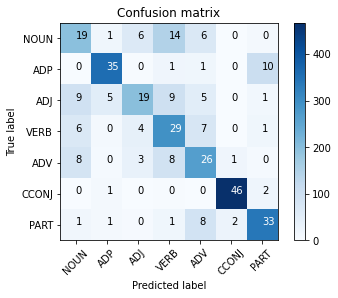

test set:
Confusion matrix, without normalization


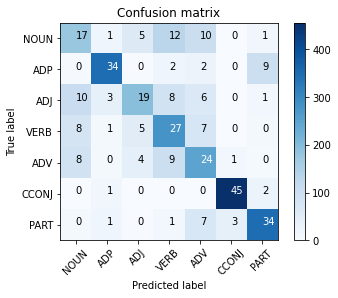

In [166]:
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)

print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 10)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

## Длина + последняя буква

accuracy on train set:
0.6717142857142857
accuracy on test set:
0.6502857142857142
train set:
Confusion matrix, without normalization


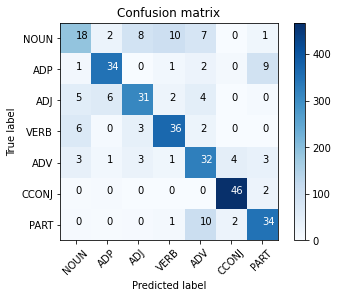

test set:
Confusion matrix, without normalization


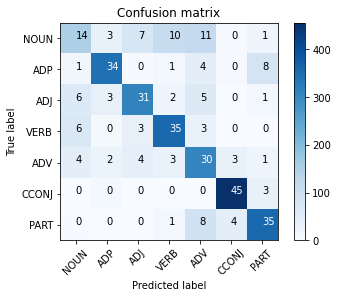

In [169]:
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)

print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 10)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

## Длина + обе буквы

accuracy on train set:
0.6702857142857143
accuracy on test set:
0.6528571428571428
train set:
Confusion matrix, without normalization


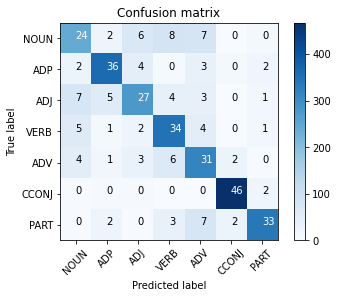

test set:
Confusion matrix, without normalization


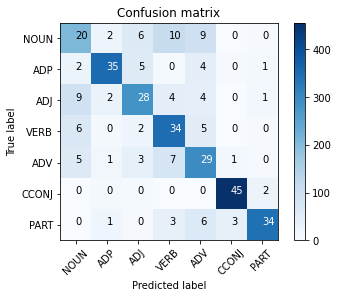

In [100]:
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)
pipe = Pipeline([('transformer',transform()),('classifier',Naive_Bayes())])
pipe.fit(larrDC,larrLB)

print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 10)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

Видно, что ключевыми признакими для успешной классификации являются длина и последняя буква. Дальнейшее увеличение количества рассматриваемых букв медленно увеличивает точность.

## KNN

In [228]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(ClLen = 100)

In [100]:
def CarArr(_word,mult = 1):
    word = copy.deepcopy(_word)
    
    if(len(word) < 3):
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        LetterPos(('a'))*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos((word[len(word) - 1]))*mult
                        ], dtype = object)
    else:
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        LetterPos((word[len(word) - 3]))*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos(word[len(word) - 1])*mult
                        ], dtype = object)
    return res

In [101]:
class transform(skl.base.TransformerMixin):
    
    def __init__(self,n = 1):
        self.n = n
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = CarArr(a[i], mult = self.n)
            
        return res

In [229]:
pipe = Pipeline([('transformer',transform(n = 6)),('classifier',KNN(k = 1))])
pipe.fit(larrDC,larrLB)

Pipeline(steps=[('transformer',
                 <__main__.transform object at 0x000001736C7C2A40>),
                ('classifier', <__main__.KNN object at 0x000001736C7C0A60>)])

accuracy on train set:
0.99
accuracy on test set:
0.7471428571428571
train set:
Confusion matrix, without normalization


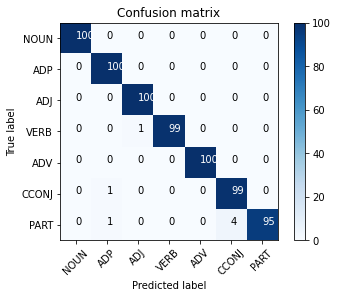

test set:
Confusion matrix, without normalization


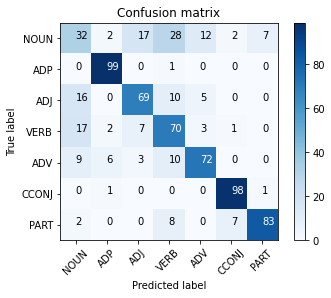

In [55]:
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("train set:")
confusion_matrix(pipe,larrDC,larrLB,class_names = Classes,normalize = False,shrink = 1)
print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

Умножение кода букв на 6

accuracy on test set:
0.7542857142857143
test set:
Confusion matrix, without normalization


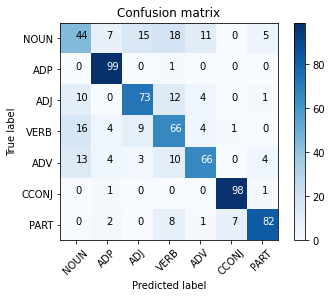

In [83]:
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

Умножение кода букв на 20

accuracy on test set:
0.7528571428571429
test set:
Confusion matrix, without normalization


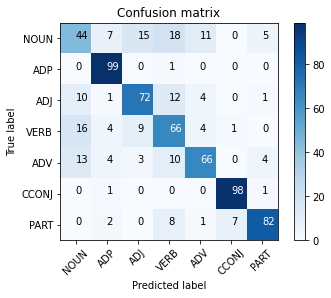

In [85]:
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

Умножение дины слова

accuracy on test set:
0.7057142857142857
test set:
Confusion matrix, without normalization


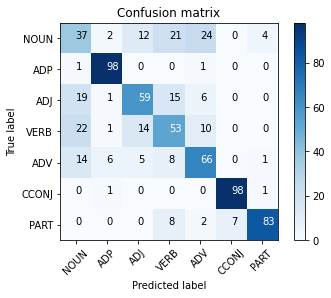

In [160]:
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

print("test set:")
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 1)

Определяем оптимальную k

In [209]:
acc_arr = []
for i in range (1,10): 
    pipe = Pipeline([('transformer',transform()),('classifier',KNN(k = i))])
    pipe.fit(larrDC,larrLB)
    acc_arr.append([i,pipe.score(larrDC,larrLB),pipe.score(tarrDC,tarrLB)])
    
acc_arr = np.array(acc_arr)

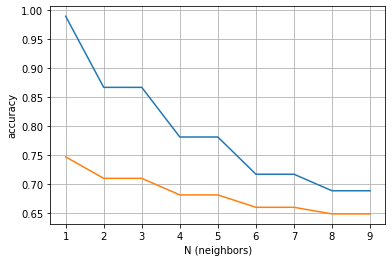

In [210]:
pylab.grid()

pylab.xlabel('N (neighbors)')
pylab.ylabel('accuracy')
pylab.plot(acc_arr[:,0],acc_arr[:,1])
pylab.plot(acc_arr[:,0],acc_arr[:,2])

Определяем оптимальный mult

In [102]:
acc_arr = []
for i in range (1,10): 
    j = i
        
    print("doing: {}".format(j))
    pipe = Pipeline([('transformer',transform(n = j)),('classifier',KNN(1))])
    pipe.fit(larrDC,larrLB)
    acc_arr.append([j,pipe.score(larrDC,larrLB),pipe.score(tarrDC,tarrLB)])
    
acc_arr = np.array(acc_arr)

doing: 1
doing: 2
doing: 3
doing: 4
doing: 5
doing: 6
doing: 7
doing: 8
doing: 9


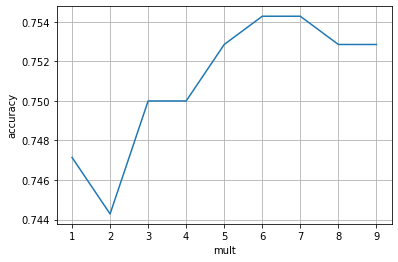

In [105]:
pylab.grid()

pylab.xlabel('mult')
pylab.ylabel('accuracy')

pylab.plot(acc_arr[:,0],acc_arr[:,2])

In [78]:
print("mult = {}".format(acc_arr[:,0][15]))
print("acc = {}".format(acc_arr[:,2][15]))

mult = 6.0
acc = 0.7542857142857143


Из-за чего возникают ошибки

In [180]:
tr = transform(n = 6)

rep = []
for i in range(100):
    mp = []
    a,b = pipe.predict([tarrDC[i]],silent = False)
    print(a == tarrLB[i])
    
    if(b[0][0] == tr.transform([tarrDC[i]])[0][0]): #одинаковая ли длина
        mp.append(1)
    else:
        mp.append(0)
        
    cnt = 0 #сколько букв не совпало
    for j in range(4):
        if(b[0][j + 1] != tr.transform([tarrDC[i]])[0][j+1]):
            cnt+=1 
    mp.append(cnt)
    mp.append(a == tarrLB[i])
    mp.append(abs(b[0][0] - tr.transform([tarrDC[i]])[0][0]))
    rep.append(mp)

---------
input feats: [1 -6 -6 -6 -6]
closest obj: [array([1, -6, -6, -6, -6], dtype=object)]
True
---------
input feats: [6 24 30 72 6]
closest obj: [array([3, 30, 30, 84, 6], dtype=object)]
False
---------
input feats: [13 0 24 72 24]
closest obj: [array([14, 0, 24, 72, 24], dtype=object)]
True
---------
input feats: [5 174 0 144 0]
closest obj: [array([4, 168, 0, 180, 6], dtype=object)]
False
---------
input feats: [4 30 60 18 144]
closest obj: [array([10, 18, 30, 6, 144], dtype=object)]
True
---------
input feats: [6 144 120 36 96]
closest obj: [array([5, 138, 114, 36, 96], dtype=object)]
True
---------
input feats: [8 144 66 36 96]
closest obj: [array([10, 138, 66, 24, 96], dtype=object)]
True
---------
input feats: [5 126 144 24 120]
closest obj: [array([5, 126, 138, 24, 108], dtype=object)]
True
---------
input feats: [9 132 120 36 156]
closest obj: [array([9, 138, 120, 36, 156], dtype=object)]
True
---------
input feats: [8 132 132 24 66]
closest obj: [array([3, 126, 126, 24, 

---------
input feats: [5 114 144 132 0]
closest obj: [array([12, 120, 138, 144, 18], dtype=object)]
True
---------
input feats: [6 24 0 102 24]
closest obj: [array([6, 24, 0, 102, 24], dtype=object)]
True
---------
input feats: [11 66 144 138 54]
closest obj: [array([9, 72, 144, 138, 54], dtype=object)]
True
---------
input feats: [10 42 54 132 36]
closest obj: [array([3, 42, 42, 144, 24], dtype=object)]
False
---------
input feats: [6 78 120 24 96]
closest obj: [array([11, 90, 120, 18, 96], dtype=object)]
True
---------
input feats: [2 78 -6 78 24]
closest obj: [array([2, 66, -6, 66, 24], dtype=object)]
True
---------
input feats: [5 114 144 132 0]
closest obj: [array([12, 120, 138, 144, 18], dtype=object)]
True
---------
input feats: [13 -6 6 108 18]
closest obj: [array([10, -6, 18, 102, 18], dtype=object)]
True
---------
input feats: [4 66 18 78 0]
closest obj: [array([4, 72, 24, 78, 0], dtype=object)]
True
---------
input feats: [6 126 0 108 18]
closest obj: [array([7, 120, 0, 108

In [203]:
correct = []
false = []
for i in rep:
    if(i[2] == True):
        correct.append([i[0],i[1],i[3]])
    
    if(i[2] == False):
        false.append([i[0],i[1],i[3]])
        
cp = 0
for i in correct: 
    if(i[0] == 1 and i[1] == 0):
        cp +=1

wp = 0
for i in false:
    if(i[0] == 1 and i[1] == 0):
        wp +=1
        
wp/= len(false)
cp/= len(correct)

c_pl_bs =0
c_bl_ps =0
for i in correct: 
    if(i[0] == 1 and i[1] != 0):
        c_pl_bs +=1
    
    if(i[0] != 1 and i[1] == 0):
        c_bl_ps +=1
        
w_pl_bs =0
w_bl_ps =0
for i in false:
    if(i[0] == 1 and i[1] != 0):
        w_pl_bs +=1
    
    if(i[0] != 1 and i[1] == 0):
        w_bl_ps +=1
        
c_pl_bs /= len(correct)
c_bl_ps /= len(correct)
w_pl_bs /= len(false)
w_bl_ps /= len(false)

In [204]:
print("avg count of missmatched letters per correctly identified word: {}".format(np.mean(np.array(correct)[:,1])))
print("avg count of missmatched letters per wrongly   identified word: {}".format(np.mean(np.array(false)[:,1])))
print("")
print("avg difference in length with correctly identified words: {}".format(np.mean(np.array(correct)[:,2])))
print("avg difference in length with wrongly   identified words: {}".format(np.mean(np.array(false)[:,2])))
print("")
print("how often do lengths match (higher = more often)")
print("avg difference in length with correctly identified words: {}".format(np.mean(np.array(correct)[:,0])))
print("avg difference in length with wrongly   identified words: {}".format(np.mean(np.array(false)[:,0])))
print("")
print("% of perfect matches in correctly identified words: {}".format(cp*100))
print("% of perfect matches in wrongly   identified words: {}".format(wp*100))
print("")
print("% of perfect len matches with letter missmatch in correctly identified words: {}".format(c_pl_bs*100))
print("% of perfect len matches with letter missmatch in wrongly   identified words: {}".format(w_pl_bs*100))
print("")
print("% of perfect letter matches with len missmatch in correctly identified words: {}".format(c_bl_ps*100))
print("% of perfect letter matches with len missmatch in wrongly   identified words: {}".format(w_bl_ps*100))

avg count of missmatched letters per correctly identified word: 1.0597014925373134
avg count of missmatched letters per wrongly   identified word: 2.515151515151515

avg difference in length with correctly identified words: 1.9850746268656716
avg difference in length with wrongly   identified words: 3.393939393939394

how often do lengths match (higher = more often)
avg difference in length with correctly identified words: 0.4925373134328358
avg difference in length with wrongly   identified words: 0.030303030303030304

% of perfect matches in correctly identified words: 35.82089552238806
% of perfect matches in wrongly   identified words: 0.0

% of perfect len matches with letter missmatch in correctly identified words: 13.432835820895523
% of perfect len matches with letter missmatch in wrongly   identified words: 3.0303030303030303

% of perfect letter matches with len missmatch in correctly identified words: 7.462686567164178
% of perfect letter matches with len missmatch in wrongl

## Выделение отдельных классов логистической регрессией

In [126]:
class transform(skl.base.TransformerMixin):
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)            
        for i in range(len(a)):
            tmp = CarArr(a[i])
            res[i] = tmp
            
        realRes = np.array([[t[0],1] for i,t in enumerate(res)])
            
        return realRes

In [127]:
def separate_class(cl,larrDC,larrLB):
    count = [0,0]
    lim = 500
    words = []
    sel_class = cl
    larr_L = []
    for i in range(len(larrLB)):
        if(larrLB[i] == sel_class):
            if(count[1] < lim):
                words.append(larrDC[i])
                larr_L.append(1)
                count[1] += 1

        else:
            if(count[0] < lim):
                words.append(larrDC[i])
                larr_L.append(0)
                count[0] += 1
    return words,larr_L

In [45]:
pipe = Pipeline([('transformer',transform()),('classifier',logistic_regression(1,lr = 0.0001))])

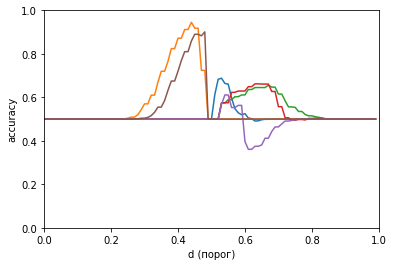

In [46]:
pipe.fit(separate_class(0,larrDC,larrLB)[0],separate_class(0,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(0,larrDC,larrLB)[0],separate_class(0,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(2,larrDC,larrLB)[0],separate_class(2,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(2,larrDC,larrLB)[0],separate_class(2,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(3,larrDC,larrLB)[0],separate_class(3,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(3,larrDC,larrLB)[0],separate_class(3,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(4,larrDC,larrLB)[0],separate_class(4,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(4,larrDC,larrLB)[0],separate_class(4,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(5,larrDC,larrLB)[0],separate_class(5,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(5,larrDC,larrLB)[0],separate_class(5,larrDC,larrLB)[1],d_span = [0,1])

#### Это разделение по длине слова, по сути хорошо выделяются только предлоги и союзы

Если добавить другие свойства, то логистическая регрессия будет неэффективна:

In [50]:
class transform(skl.base.TransformerMixin):
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)            
        for i in range(len(a)):
            tmp = CarArr(a[i])
            res[i] = tmp
            
        realRes = np.array([[t[0],t[4],1] for i,t in enumerate(res)])
        #,t[1],t[2],t[3],
            
        return realRes

In [53]:
pipe = Pipeline([('transformer',transform()),('classifier',logistic_regression(2,lr = 0.0001))])

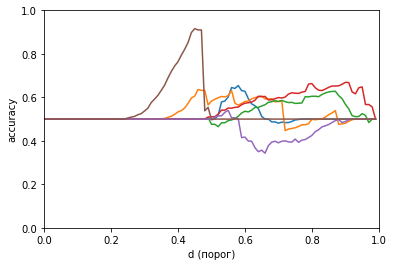

In [54]:
pipe.fit(separate_class(0,larrDC,larrLB)[0],separate_class(0,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(0,larrDC,larrLB)[0],separate_class(0,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(2,larrDC,larrLB)[0],separate_class(2,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(2,larrDC,larrLB)[0],separate_class(2,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(3,larrDC,larrLB)[0],separate_class(3,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(3,larrDC,larrLB)[0],separate_class(3,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(4,larrDC,larrLB)[0],separate_class(4,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(4,larrDC,larrLB)[0],separate_class(4,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(5,larrDC,larrLB)[0],separate_class(5,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(5,larrDC,larrLB)[0],separate_class(5,larrDC,larrLB)[1],d_span = [0,1])

In [55]:
class transform(skl.base.TransformerMixin):
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)            
        for i in range(len(a)):
            tmp = CarArr(a[i])
            res[i] = tmp
            
        realRes = np.array([[t[0],t[1],t[2],t[3],t[4],1] for i,t in enumerate(res)])
            
        return realRes

In [56]:
pipe = Pipeline([('transformer',transform()),('classifier',logistic_regression(5,lr = 0.0001))])

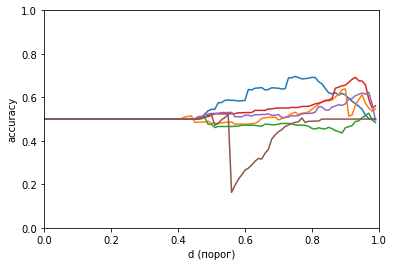

In [57]:
pipe.fit(separate_class(0,larrDC,larrLB)[0],separate_class(0,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(0,larrDC,larrLB)[0],separate_class(0,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(2,larrDC,larrLB)[0],separate_class(2,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(2,larrDC,larrLB)[0],separate_class(2,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(3,larrDC,larrLB)[0],separate_class(3,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(3,larrDC,larrLB)[0],separate_class(3,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(4,larrDC,larrLB)[0],separate_class(4,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(4,larrDC,larrLB)[0],separate_class(4,larrDC,larrLB)[1],d_span = [0,1])
pipe.fit(separate_class(5,larrDC,larrLB)[0],separate_class(5,larrDC,larrLB)[1])
DACforPipe(pipe,separate_class(5,larrDC,larrLB)[0],separate_class(5,larrDC,larrLB)[1],d_span = [0,1])

Пример использования для выделенния предлогов:

Да, тут, по сути, можно было вручную указать длину, при которой слово перестает считаться предлогом и было бы то же самое

In [133]:
pipe = Pipeline([('transformer',transform()),('classifier',logistic_regression(1,lr = 0.0001))])
pipe.fit(separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1])
pipe[1].d = 0.41
print("accuracy on train set:")
print(pipe.score(separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1]))
print("accuracy on test set:")
print(pipe.score(separate_class(1,tarrDC,tarrLB)[0],separate_class(1,tarrDC,tarrLB)[1]))


accuracy on train set:
0.912
accuracy on test set:
0.856


In [146]:
basic_metrics(pipe,separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1],silent = False)

accuracy: 0.912 (чем больше ложных, тем меньше)
precision: 0.8772893772893773 (чем больше ложнопозитивных, тем меньше)
recall: 0.958 (чем больше ложнонегативных, тем меньше)
specificity: 0.866 (чем больше негативных классифицировано неверно, тем меньше)
sencitivity: 0.958 (чем больше позитивных классифицировано неверно, тем меньше)


(0.912, 0.8772893772893773, 0.958, 0.866, 0.958)

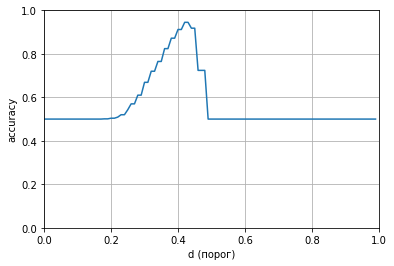

In [136]:
DACforPipe(pipe,separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1])

Confusion matrix, without normalization


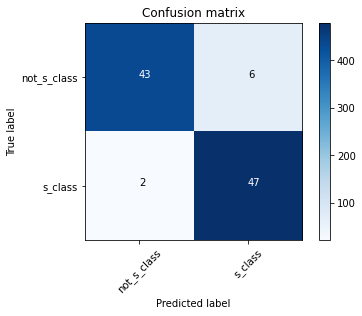

In [147]:
confusion_matrix(pipe,separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1],
                 class_names = ["not_s_class","s_class"],normalize = False, shrink = 10)

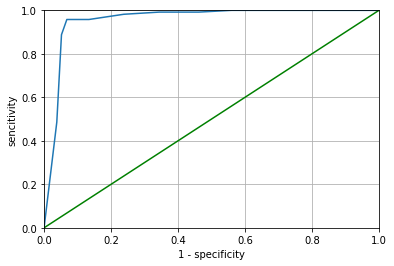

In [135]:
rocForPipe(pipe,separate_class(1,larrDC,larrLB)[0],separate_class(1,larrDC,larrLB)[1])

Линейная регрессия и подобные ей алгоритмы весьма ожидаемо неэффективны при классификации слов, так как они воспринимают признаки, как координаты в непрерывном пространстве, а буквы алфавита, обозначенные своим порядковым номером таковыми не являются.

## Решение задачи моделями skl

С использованием самого успешного трансформера и можелей KNN и наивной Байесовской классификации

In [86]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [214]:
def CarArr(_word,mult = 1):
    word = copy.deepcopy(_word)
    
    if(len(word) < 3):
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        LetterPos(('a'))*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos((word[len(word) - 1]))*mult
                        ], dtype = object)
    else:
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        LetterPos((word[len(word) - 3]))*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos(word[len(word) - 1])*mult
                        ], dtype = object)
    return res

In [215]:
class transform(skl.base.TransformerMixin):
    
    def __init__(self,n = 1):
        self.n = n
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = CarArr(a[i], mult = self.n)
            
        return np.array(res,dtype = 'int')

In [232]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset()

#### Naive Bayes

In [58]:
pipe = Pipeline([('transformer',transform()),('classifier',GaussianNB())])
pipe.fit(larrDC,larrLB)

Pipeline(steps=[('transformer',
                 <__main__.transform object at 0x0000018D06526E90>),
                ('classifier', GaussianNB())])

In [59]:
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

accuracy on train set:
0.5048571428571429
accuracy on test set:
0.48828571428571427


Confusion matrix, without normalization


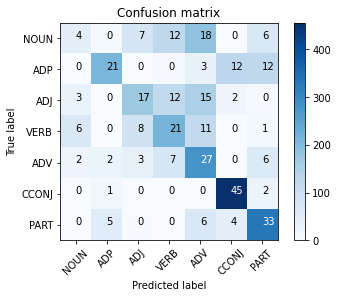

In [60]:
confusion_matrix(pipe,tarrDC,tarrLB,class_names = Classes,normalize = False,shrink = 10)

####  KNN

accuracy on train set:
0.9857142857142858
accuracy on test set:
0.8425714285714285
Confusion matrix, without normalization


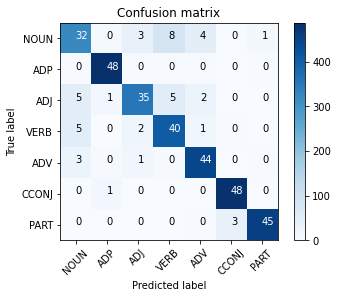

In [216]:
pipe = Pipeline([
    ('transformer',transform(n = 1)),
    ('classifier',KNeighborsClassifier(n_neighbors = 1))])
pipe.fit(larrDC,larrLB)

print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

confusion_matrix(pipe,tarrDC,tarrLB,
                 class_names = Classes,
                 normalize = False,
                 shrink = 10)

accuracy on train set:
0.9857142857142858
accuracy on test set:
0.8542857142857143
Confusion matrix, without normalization


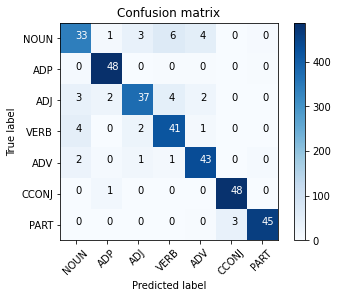

In [234]:
pipe = Pipeline([
    ('transformer',transform(n = 6)),
    ('classifier',KNeighborsClassifier(n_neighbors = 1))])
pipe.fit(larrDC,larrLB)

print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

confusion_matrix(pipe,tarrDC,tarrLB,
                 class_names = Classes,
                 normalize = False,
                 shrink = 10)

Naive Bayes из skl показал чуть меньшую точность, чем моя реализация, KNN - несколько большую

Так как реализация KNN в skl на порядок более быстрая, чем моя, дальнейшие исследования с KNN будет удобнее делать с ней

Дополнительные исследования с KNN:

In [97]:
acc_arr = []
for i in range (1,10): 
    pipe = Pipeline([('transformer',transform()),('classifier',KNeighborsClassifier(n_neighbors = i))])
    pipe.fit(larrDC,larrLB)
    acc_arr.append([i,pipe.score(larrDC,larrLB),pipe.score(tarrDC,tarrLB)])
    
acc_arr = np.array(acc_arr)

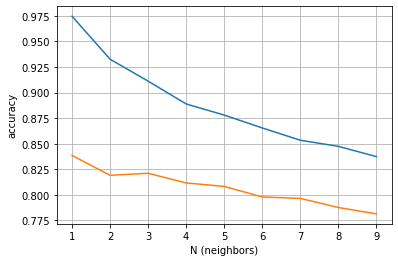

In [99]:
pylab.grid()

pylab.xlabel('N (neighbors)')
pylab.ylabel('accuracy')
pylab.plot(acc_arr[:,0],acc_arr[:,1])
pylab.plot(acc_arr[:,0],acc_arr[:,2])

Очевидно, что, чем меньше соседей рассматривается, тем лучше результат

На большем датасете:

In [219]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(selLen = 50000, ClLen = 5000)

accuracy on train set:
0.9685428571428571
accuracy on test set:
0.9193714285714286
Confusion matrix, without normalization


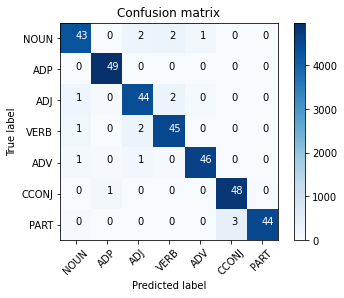

In [226]:
pipe = Pipeline([
    ('transformer',transform(n = 6)),
    ('classifier',KNeighborsClassifier(n_neighbors = 1))])
pipe.fit(larrDC,larrLB)
print("accuracy on train set:")
print(pipe.score(larrDC,larrLB))
print("accuracy on test set:")
print(pipe.score(tarrDC,tarrLB))

confusion_matrix(pipe,tarrDC,tarrLB,
                 class_names = Classes,
                 normalize = False,
                 shrink = 100)

### Сохранение моделей

#### KNN skl

In [235]:
with open('skl_knn.pkl', 'wb') as pickle_out: 
    pickle.dump(pipe, pickle_out)
    
with open('skl_knn_dataset.pkl', 'wb') as pickle_out: 
    pickle.dump((larrLB,larrDC,tarrLB,tarrDC), pickle_out)

#### My KNN

In [230]:
with open('my_knn.pkl', 'wb') as pickle_out: 
    pickle.dump(pipe, pickle_out)
    
with open('my_knn_dataset.pkl', 'wb') as pickle_out: 
    pickle.dump((larrLB,larrDC,tarrLB,tarrDC), pickle_out)

#### Оптимальная настройка naive bayes

In [238]:
with open('my_nb.pkl', 'wb') as pickle_out: 
    pickle.dump(pipe, pickle_out)
    
with open('my_nb_dataset.pkl', 'wb') as pickle_out: 
    pickle.dump((larrLB,larrDC,tarrLB,tarrDC), pickle_out)

Проверка

In [239]:
with open('skl_knn.pkl', 'rb') as pickle_in: 
    tst = pickle.load(pickle_in)
    
with open('skl_knn_dataset.pkl', 'rb') as pickle_in: 
    tst_set = pickle.load(pickle_in)
    
print(tst.score(tst_set[1],tst_set[0]))

0.9857142857142858


In [240]:
with open('my_knn.pkl', 'rb') as pickle_in: 
    tst = pickle.load(pickle_in)
    
with open('my_knn_dataset.pkl', 'rb') as pickle_in: 
    tst_set = pickle.load(pickle_in)
    
print(tst.score(tst_set[1],tst_set[0]))

0.99


In [241]:
with open('my_nb.pkl', 'rb') as pickle_in: 
    tst = pickle.load(pickle_in)
    
with open('my_nb_dataset.pkl', 'rb') as pickle_in: 
    tst_set = pickle.load(pickle_in)
    
print(tst.score(tst_set[1],tst_set[0]))

0.6931428571428572


## Использование нейросети

просто инетресно, что получится

In [17]:
def overlearn(tracearr):
    acc = 0
    for a in tracearr:
        if(a[2] < acc):
            return(int(a[0] -1))
        acc = a[2]
    return 0

def plotLearning(arr):
    ol = overlearn(arr)
    plt.plot(arr[:,0],arr[:,2],color = "blue")
    plt.grid(True)
    plt.axis([0,arr.shape[0] - 1,0,1])
    plt.title('Learning progress', fontsize=15, fontname='Times New Roman')
    plt.xlabel("epochs",color = "grey")
    plt.ylabel("accuracy",color = "grey")
    if(ol):
        plt.axvline(x=ol, ymin=0, ymax=1, color="red", linewidth=2)
    plt.show()

    plt.plot(arr[:,0],arr[:,1],color = "blue")
    plt.grid(True)
    plt.title('Loss change', fontsize=15, fontname='Times New Roman')
    plt.xlabel("epochs",color = "grey")
    plt.ylabel("loss",color = "grey")
    if(ol):
        plt.axvline(x=ol, ymin=0, ymax=1, color="red", linewidth=2)
    plt.show()

In [34]:
def train(net, dataloader, validloader, epochs=10, lr=0.05, silent = False):
    criterion = torch.nn.CrossEntropyLoss(weight = class_weights)
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    for valdata in validloader:
        val_x, val_y = valdata
    traceArr = []
    
    
    loss1 = criterion(net(val_x),val_y)
    acc = (torch.argmax(net(val_x),dim = 1) == val_y).float().mean()
    if not silent:
        print(f"begin train: start loss = {loss1}, val acc = {acc}")
    traceArr.append((0,float(loss1),float(acc)))
    
    for ep in range(epochs):
        for (x,y) in dataloader:
            z = net(x)
            
            optim.zero_grad()
            
            loss = criterion(z,y)
            loss.backward()
    
            optim.step()
            
        acc = (torch.argmax(net(val_x),dim = 1) == val_y).float().mean()
        if not silent:
            print(f"Epoch {ep}: last batch loss = {loss}, val acc = {acc}")
        traceArr.append((ep + 1,float(loss),float(acc)))
    return np.array(traceArr)

def test(net,testloader,silent = False):
    criterion = torch.nn.CrossEntropyLoss()
    for testdata in testloader:
        test_x, test_y = testdata
    testloss = criterion(net(test_x),test_y)
    testacc = (torch.argmax(net(test_x),dim = 1) == test_y).float().mean()
    if not silent:
        print(f"test: loss = {testloss}, acc = {testacc}")
    return (float(testloss), float(testacc))

In [ ]:
#инициализация сети
net = torch.nn.Sequential(
    torch.nn.Linear(len(larrXX[0]),10),
    torch.nn.Sigmoid(),
    torch.nn.Linear(10,20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20,len(Classes)),
    torch.nn.Softmax(dim = 0))
print(net)

class_weights = skl.utils.class_weight.compute_class_weight(
                class_weight = "balanced",
                classes = np.unique(np.array(larrLB)),
                y = np.array(larrLB)                                                   
            )

class_weights = torch.tensor(class_weights,dtype = torch.float32)

In [43]:


#формирование загрузчисков
dataset = torch.utils.data.TensorDataset(torch.tensor(larrXX,dtype=torch.float32),
                                         torch.tensor(larrLB,dtype=torch.long))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=10)

valset = torch.utils.data.TensorDataset(torch.tensor(tarrXX,dtype=torch.float32),
                                         torch.tensor(tarrLB,dtype=torch.long))
valloader = torch.utils.data.DataLoader(valset,batch_size=len(larrLB))

testset = torch.utils.data.TensorDataset(torch.tensor(tarrXX,dtype=torch.float32),
                                         torch.tensor(tarrLB,dtype=torch.long))
testloader = torch.utils.data.DataLoader(testset,batch_size=len(tarrLB))

test(net,testloader)

#тренировка сети
arr2 = train(net, dataloader, valloader, epochs=200,lr = 0.0004)

#проверка на тестовом сете
test(net,testloader)

test: loss = 1.9458316564559937, acc = 0.6898936629295349
begin train: start loss = 1.9458253383636475, val acc = 0.6898936629295349
Epoch 0: last batch loss = 1.9741184711456299, val acc = 0.6907696723937988
Epoch 1: last batch loss = 1.9738632440567017, val acc = 0.6912614703178406
Epoch 2: last batch loss = 1.9736632108688354, val acc = 0.6915380954742432
Epoch 3: last batch loss = 1.9734957218170166, val acc = 0.6917532682418823
Epoch 4: last batch loss = 1.9733638763427734, val acc = 0.6920913457870483
Epoch 5: last batch loss = 1.9732664823532104, val acc = 0.6925985217094421
Epoch 6: last batch loss = 1.9732004404067993, val acc = 0.6928136944770813
Epoch 7: last batch loss = 1.9731618165969849, val acc = 0.6930134892463684
Epoch 8: last batch loss = 1.973145604133606, val acc = 0.6933823227882385
Epoch 9: last batch loss = 1.9731470346450806, val acc = 0.6939048171043396
Epoch 10: last batch loss = 1.9731619358062744, val acc = 0.6943197846412659
Epoch 11: last batch loss = 1.9

Epoch 106: last batch loss = 1.9734858274459839, val acc = 0.6725579500198364
Epoch 107: last batch loss = 1.9734855890274048, val acc = 0.6723735332489014
Epoch 108: last batch loss = 1.9734854698181152, val acc = 0.6718817353248596
Epoch 109: last batch loss = 1.9734855890274048, val acc = 0.671605110168457
Epoch 110: last batch loss = 1.9734858274459839, val acc = 0.6707291007041931
Epoch 111: last batch loss = 1.9734866619110107, val acc = 0.6704985499382019
Epoch 112: last batch loss = 1.9734872579574585, val acc = 0.670360267162323
Epoch 113: last batch loss = 1.9734883308410645, val acc = 0.670360267162323
Epoch 114: last batch loss = 1.9734896421432495, val acc = 0.6700221300125122
Epoch 115: last batch loss = 1.973490834236145, val acc = 0.6698223352432251
Epoch 116: last batch loss = 1.9734925031661987, val acc = 0.6693920493125916
Epoch 117: last batch loss = 1.9734939336776733, val acc = 0.669622540473938
Epoch 118: last batch loss = 1.973495364189148, val acc = 0.669100046

(1.9458329677581787, 0.6930288076400757)

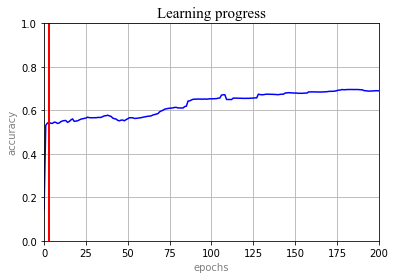

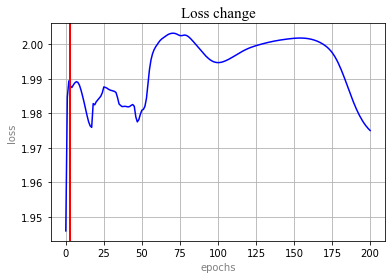

In [42]:
plotLearning(arr)

Confusion matrix, without normalization


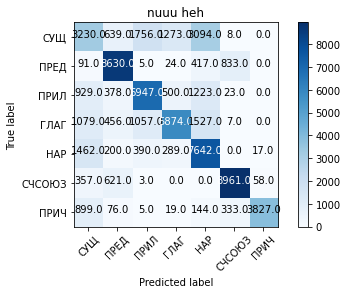

In [46]:
plot_confusion_matrix(confusion_matrix(larrLB, np.argmax(net(torch.tensor(larrXX,dtype=torch.float32)).detach(),axis=1), n_prop = len(ClassesRU)), 
                      ClassesRU,title='nuuu heh', normalize = False, do_print = True)

Confusion matrix, without normalization


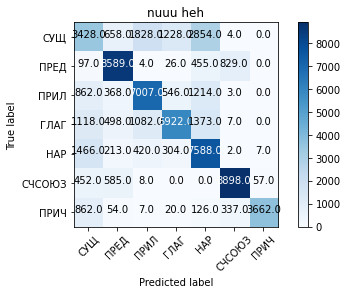

In [47]:
plot_confusion_matrix(confusion_matrix(tarrLB, np.argmax(net(torch.tensor(tarrXX,dtype=torch.float32)).detach(),axis=1), n_prop = len(ClassesRU)), 
                      ClassesRU,title='nuuu heh', normalize = False, do_print = True)

По истории обучения видно, что точность нарастает хоть и медленно, но уверенно, и при достаточном количестве эпох может достичь приемлемых значений.

## Вспомогательные функции

In [1]:
def plot_boundary(positive_examples, negative_examples, weights,is_special = 0,special = None):
    upper = 0
    lower = 0
    for a in positive_examples:
        if a[0] > upper:
            upper = a[0]
        if a[1] > upper:
            upper = a[1]
            
        if a[0] < lower:
            lower = a[0]
        if a[1] < lower:
            lower = a[1]
    
    for a in negative_examples:
        if a[0] > upper:
            upper = a[0]
        if a[1] > upper:
            upper = a[1]
            
        if a[0] < lower:
            lower = a[0]
        if a[1] < lower:
            lower = a[1]
            
            
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([lower, upper], dtype = 'float32')
        else:
            y = np.array([lower, upper], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([lower, upper], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.grid()
    pylab.xlim(lower, upper)
    pylab.ylim(lower, upper)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    if(is_special != 0):
        pylab.plot(special[:,0], special[:,1], 'mo')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

In [2]:
def plot_boundary_L(positive_examples, negative_examples, weights,is_special = 0,special = None):
    upper = 0
    lower = 0
    for a in positive_examples:
        if a[0] > upper:
            upper = a[0]
        if a[1] > upper:
            upper = a[1]
            
        if a[0] < lower:
            lower = a[0]
        if a[1] < lower:
            lower = a[1]
    
    for a in negative_examples:
        if a[0] > upper:
            upper = a[0]
        if a[1] > upper:
            upper = a[1]
            
        if a[0] < lower:
            lower = a[0]
        if a[1] < lower:
            lower = a[1]
            
            
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([lower, upper], dtype = 'float32')
        else:
            y = np.array([lower, upper], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([lower, upper], dtype='float32')
        y = -(weights[0] * x)/weights[1]

    pylab.grid()
    pylab.xlim(lower, upper)
    pylab.ylim(lower, upper)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    if(is_special != 0):
        pylab.plot(special[:,0], special[:,1], 'mo')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()